In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import cv2
import random
import numpy as np
import json

In [2]:
from preprocess_df import processed_driver_log, drive_log_df

During the first attempt, NVIDIA model was used to set up baseline model. However, I had difficulty to have a baseline model working. After switching among different model architecture, such as popular comma.ai model and a few self design model architectures. After burning many GPU hours experimenting different parameters, data preprocessing strategies. I still wouldn't be able to have a stable model that can succesfully drive around track 1 without staying on track consistently.

After talking to practioners in the field, seeking support from community and reading papers, I have a better understanding of the problem we are tackling.

## Garbage In Garbage Out
Without basic understanding of data for training network. Archecture design and parameters tuning will mostly become a blind effort. After realizing how statistical features of training data will impact how network "learn" or "encode", I start to understand why my model doesn't produce acceptable results even essentially they are following classical models architecture by trying data augmentation and training strategies.

## Source organization

    src/
        config.py  // hyperparameters
        drive.py // modified for testing different speed setting and debuggin
        image_utils.py 
        preprocess_df.py // pandas df preprocessing
        train.py
        train_utils.py
        run.sh // train or drive

## Data Augmentation
The actual unit of steering input value is not important, as it is mostly a scale factor taken by simulator

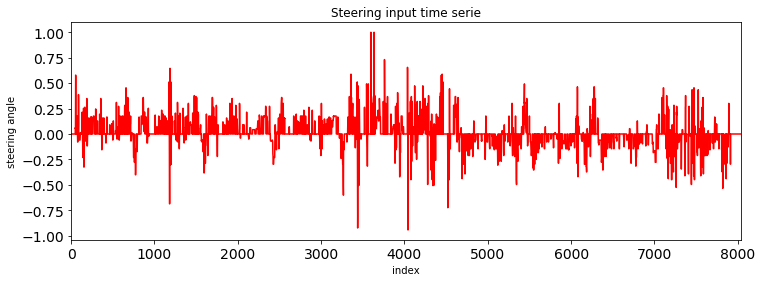

In [19]:
drive_log_df.steering.plot(title='Steering input time serie', fontsize=14, figsize=(12,4), color= 'r')
plt.xlabel('index')
plt.ylabel('steering input')
plt.show()

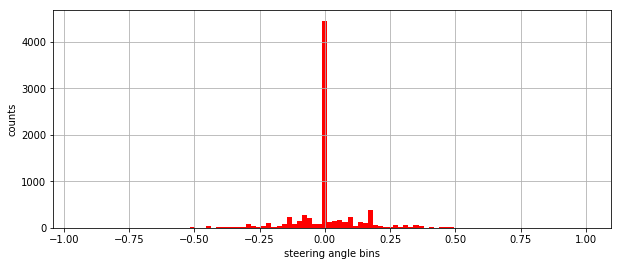

Dataset size 8036


In [4]:
def visualize_dataset_distribution(df):
    plt.figure(figsize=(10, 4))
    df.steering.hist(bins=100, color='r')
    plt.xlabel("steering angle bins")
    plt.ylabel("counts")
    plt.show()
    print("Dataset size", len(df.steering.index))
visualize_dataset_distribution(drive_log_df)

The training set predominantly consists of row with zero steering input, which makes the natural data distribution significantly biased toward zero steering input behavior.

in src/preprocess_df.py file, multiple methods are used to augment provided dataset with above statistical features to below statistical feature.

First, removed large quantity of minor steering input (including zero input) from dataset. Please see function remove_bias in preprocess_df.py for implementation. When absolute input is less that 0.02 is smaller than 0.02, even it is not zero, we consider as noise.

Then we use all three cameras as input references. Without camera geometrical configuration or calibration information. We use static correction factor to compensate steering input. please see aug_l_c_r_df for implementation details

Images corresponds to steering inputs larger than 0.07 are also flipped, hence this steering input larger than this threshold value is considered for training vehicle to "save" itself from driving off the track.

Finally, a translation is introduced offset steering input similar to using left and right camera. A linear correction factor is used to calculate corresponding steering input after image translation. See shift_image function for more information, please.

As we can see the processed data distribution is closer to normal distribution between -1 and 1

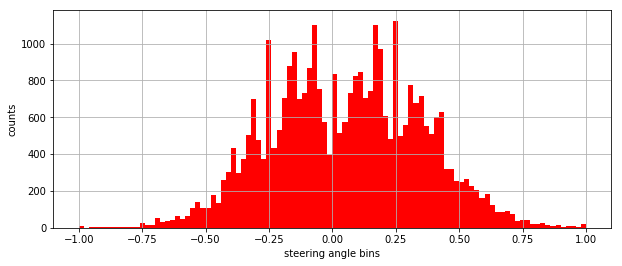

Dataset size 33066


In [20]:
visualize_dataset_distribution(processed_driver_log)

In [6]:
# processed_driver_log.reset_index(inplace=True)
# processed_driver_log.head()
processed_driver_log.head()

,image,steering,is_flipped,tx
0,IMG/left_2016_12_01_13_31_14_194.jpg,0.25,False,0.0
1,IMG/center_2016_12_01_13_31_14_194.jpg,0.00,False,0.0
2,IMG/right_2016_12_01_13_31_14_194.jpg,-0.25,False,0.0
3,IMG/left_2016_12_01_13_31_14_904.jpg,0.25,False,0.0
4,IMG/center_2016_12_01_13_31_14_904.jpg,0.00,False,0.0


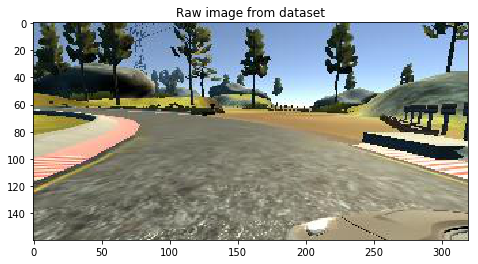

In [7]:
import matplotlib.image as mpimg
plt.figure(figsize=(10, 4))
row_0 = processed_driver_log.iloc[0]
image_path = row_0.image.strip()
image = mpimg.imread("../data/{0}".format(image_path))
plt.imshow(image)
plt.title("Raw image from dataset")
plt.show()
print("Image Shape", image.shape)

## Images Preprocessing
The small model trained using CPU is mostly inspired by below blog

https://medium.com/@xslittlegrass/self-driving-car-in-a-simulator-with-a-tiny-neural-network-13d33b871234

Limited ROI is set to 
    * reduce noise/irrelevant input 
    * Reduce computational load. 
    
Image shape ratio is retained after cropping, model introduced later follows same input shape for extracting features.

In [21]:
from image_utils import *

Below image illustrate a 15 pixel translation introduced before selectin S channel after image converted to HSV space of above image.
This part of track is challenging, sudden surface change and roadside balusters may be recognized by network as another bridges. hence drive off the track.

Using single channel data also helps to reduce computational load

This translation variable will be introduced randomly to images.

The image is finally cropped to width and height set in config.py as suggested in references, converting to HSV space works perfectly for differentiating road surface and false signal.

For the time being, model used in final submission input shape is 32x64 (HxW). Another image below shows 16x32 model has potential to be a stable model as pixelized image is still able to capture major track surface features.

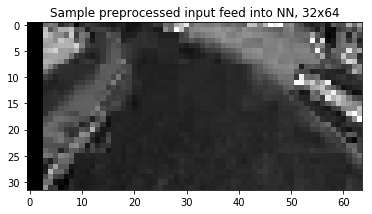

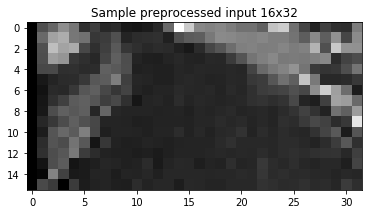

In [26]:
plt.figure(figsize=(6, 6))
plt.imshow(crop_image(color_select(translate_image(image, 15))), cmap='gray')
plt.title('Sample preprocessed input feed into NN, 32x64')
plt.show()


plt.figure(figsize=(6, 6))
plt.imshow(crop_image(color_select(translate_image(image, 15)), ROI=(65, 125), size=(32, 16)), cmap='gray')
plt.title('Sample preprocessed input 16x32')
plt.show()


Obtained 32x64 feature image fed into tiny network introduced later is

## Build the model


### Main Model

In [10]:
from train_utils import load_features_and_labels, save_model

In [11]:
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, ELU, BatchNormalization, Lambda, merge, MaxPooling2D, Input, Activation
from keras.layers.convolutional import Convolution2D, Cropping2D, Conv2D
# from keras.utils.visualize_util import plot
from keras.optimizers import Adam
from keras.callbacks import Callback, RemoteMonitor
import keras.backend as K

Using TensorFlow backend.


In [12]:
from model import model

Main model
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 32, 64, 1)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 30, 62, 2)     20          lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 7, 15, 2)      0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 7, 15, 2)      0           maxpooling2d_1[0][0]             
________________________________________________________________________________

## Driving and training

Please see src/run.sh for 
* how to drive around track 1
* traing model

It reserves 30 percent of augmented data as validation sets. There are more advanced training strategy can be applied such as early stop. 7 to 8 epochs using adam optimizer is enough to achieve stable MSE (mean square error) over 5 to 7 epochs.

## Future improvments

If time allowed, I would love to streamline intermediate layer output visulization which may help us understand this simple model's learning process under different stages
